In [51]:
from math import sqrt
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from statsmodels import tsa
import statsmodels.api as sm

import dask
from multiprocessing import cpu_count
from distributed import Client
#from joblib import Parallel
#from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from load_data import load_data

register_matplotlib_converters()

plt.rc('figure',figsize=(16,12))

In [2]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

## Analysis of just the sea ice concentration time series

In [5]:
pabrc = load_data_local('station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')

<AxesSubplot:>

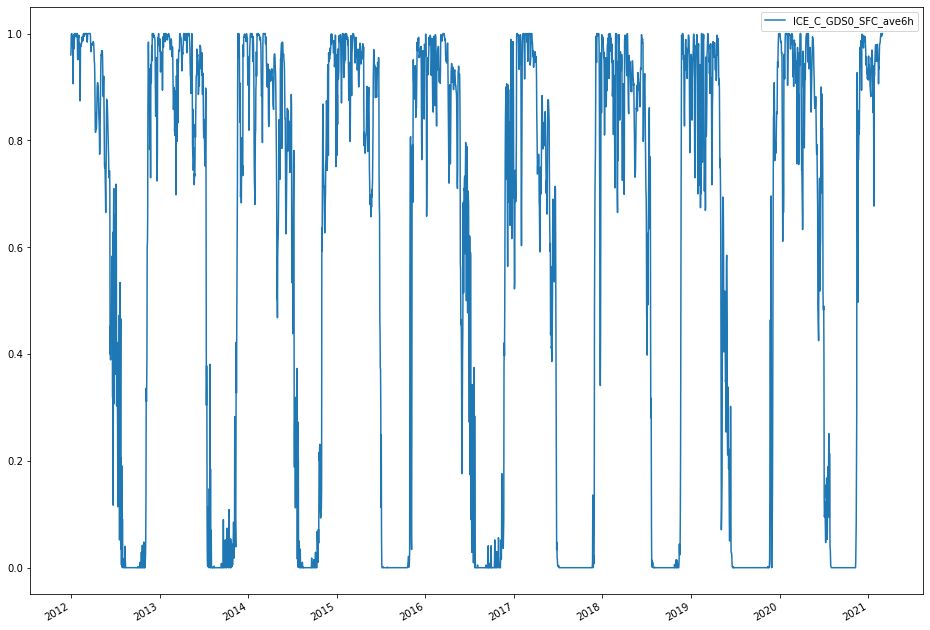

In [6]:
pabrc.plot()

### Evaulate autocorrelation


- Exponential looking ACF probably indicates an AR(1) model.


In [30]:
# Default is lag of 40, you know the it should be at least 365
pabrc_ic_acf = stattools.acf(pabrc)

/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0, 0.5, 'ACF')

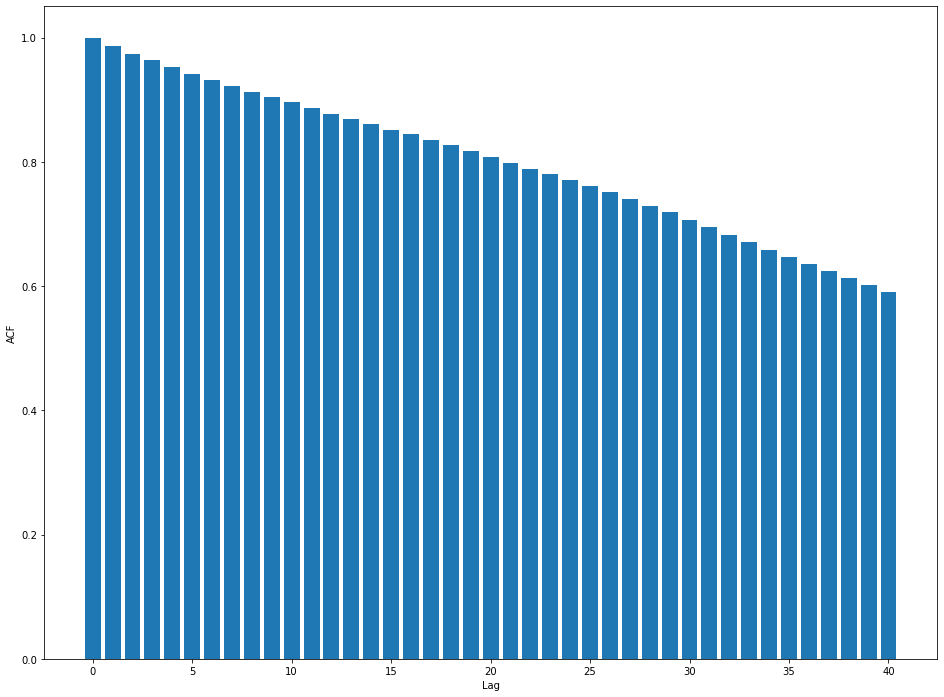

In [31]:
plt.bar(range(len(pabrc_ic_acf)), pabrc_ic_acf)
plt.xlabel('Lag')
plt.ylabel('ACF')

Text(0, 0.5, 'ACF')

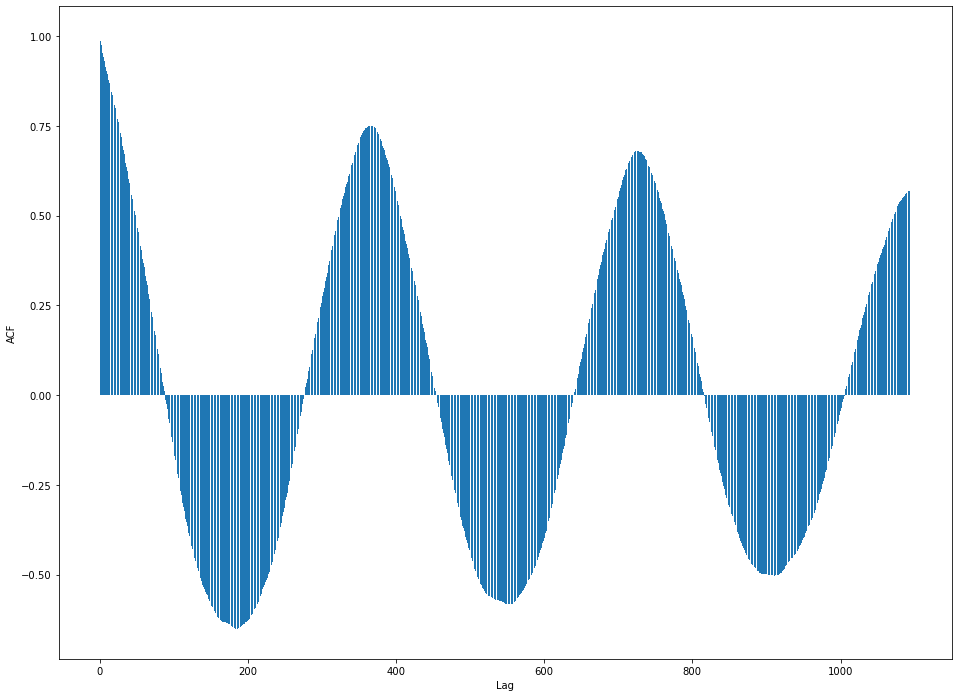

In [32]:
# lag 3 years - yup, it shows things
pabrc_ic_acf = stattools.acf(pabrc, nlags=365*3, fft=True)
plt.bar(range(len(pabrc_ic_acf)), pabrc_ic_acf)
plt.xlabel('Lag')
plt.ylabel('ACF')

In [15]:
ar = tsa.ar_model.AutoReg(pabrc, )

array([1.82243137e-01, 1.79679206e-01, 1.77521795e-01, ...,
       1.60285946e-04, 1.03774998e-04, 5.15619051e-05])

In [33]:
pabrc_ic_acovf = stattools.acovf(pabrc)

/env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'ACOVF')

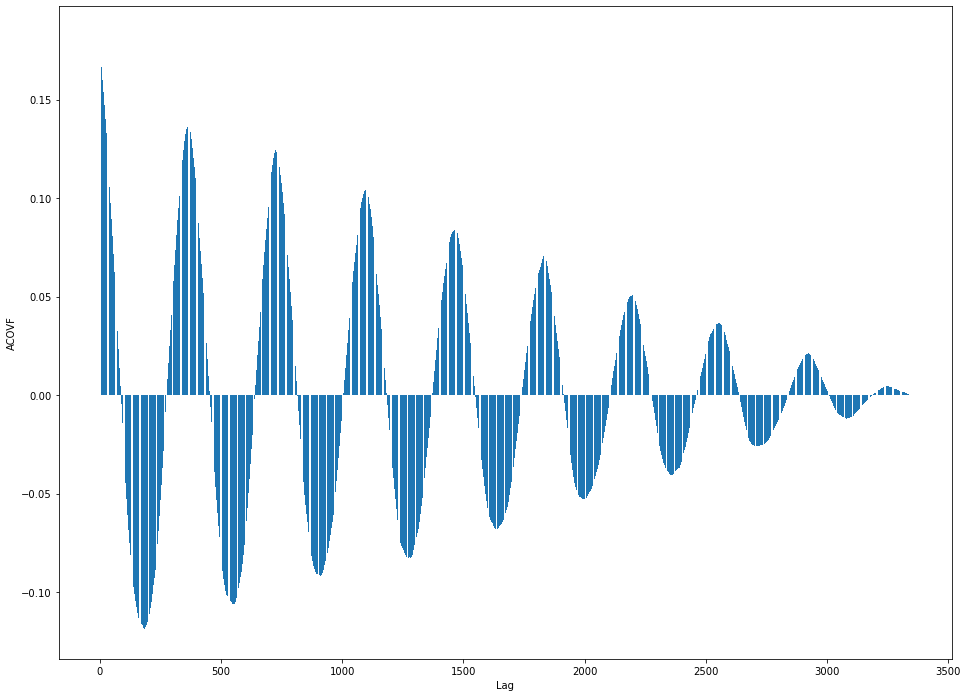

In [38]:
plt.bar(range(len(pabrc_ic_acovf)), pabrc_ic_acovf)
plt.xlabel('Lag')
plt.ylabel('ACOVF')

#### SARIMA/SARIMAX

#### Ensure stationarity

Constant mean, variance, autocorrelation structure, no periodic component

<AxesSubplot:>

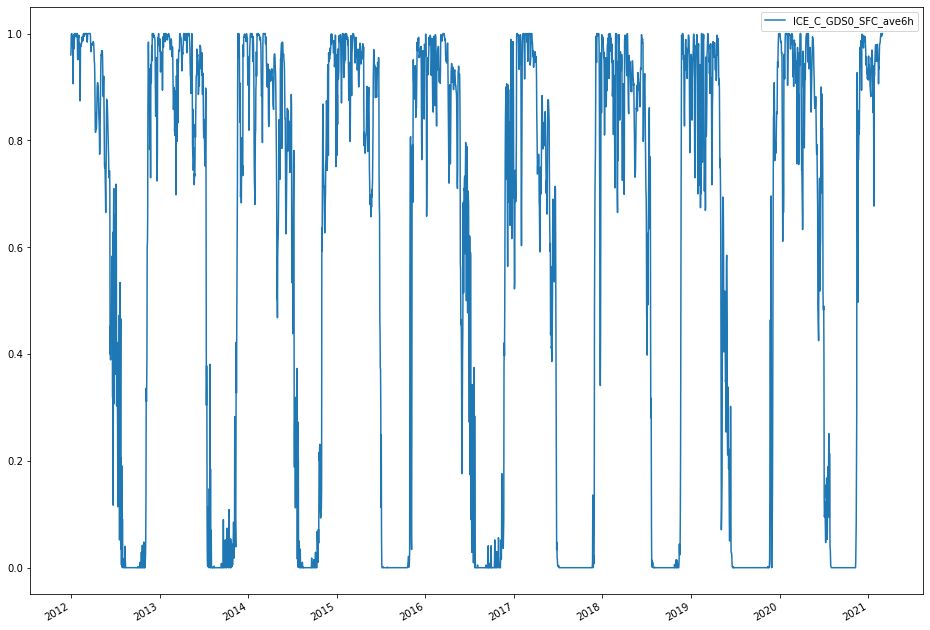

In [53]:
pabrc.plot()

In [55]:
# take diff to see how things look for arima
pabrc_diff = pabrc.diff()

<AxesSubplot:>

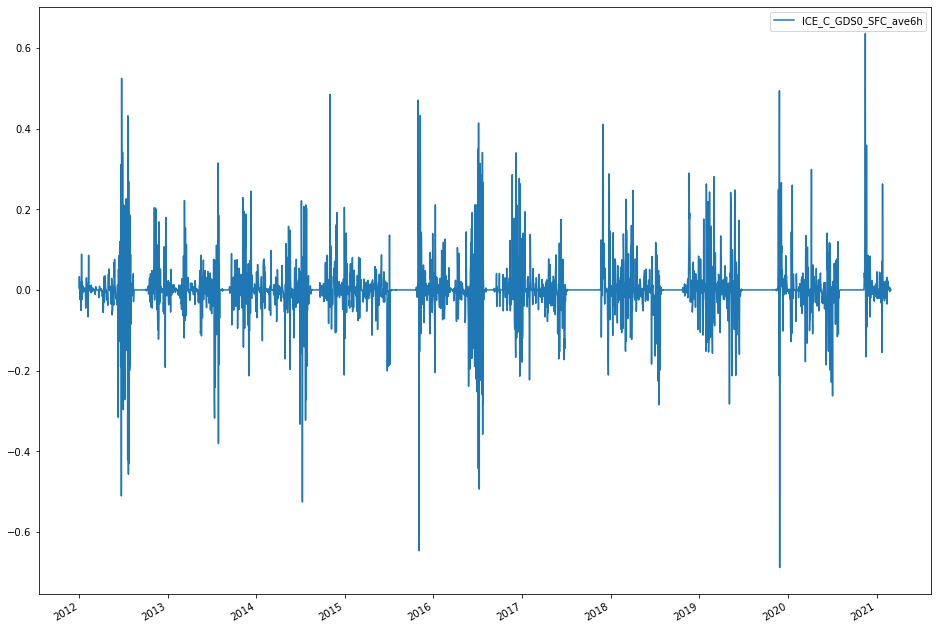

In [57]:
pabrc_diff.plot()

In [71]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = stattools.adfuller(pabrc)

In [72]:
# null hypthoesis is data is not stationary.
# pvalue ~0, so we reject null hypothesis -> the data is stationary
adf

-4.678636207081134

In [73]:
pvalue

9.22828512094755e-05

#### ACF + PACF plots

Will show autocorrelation 

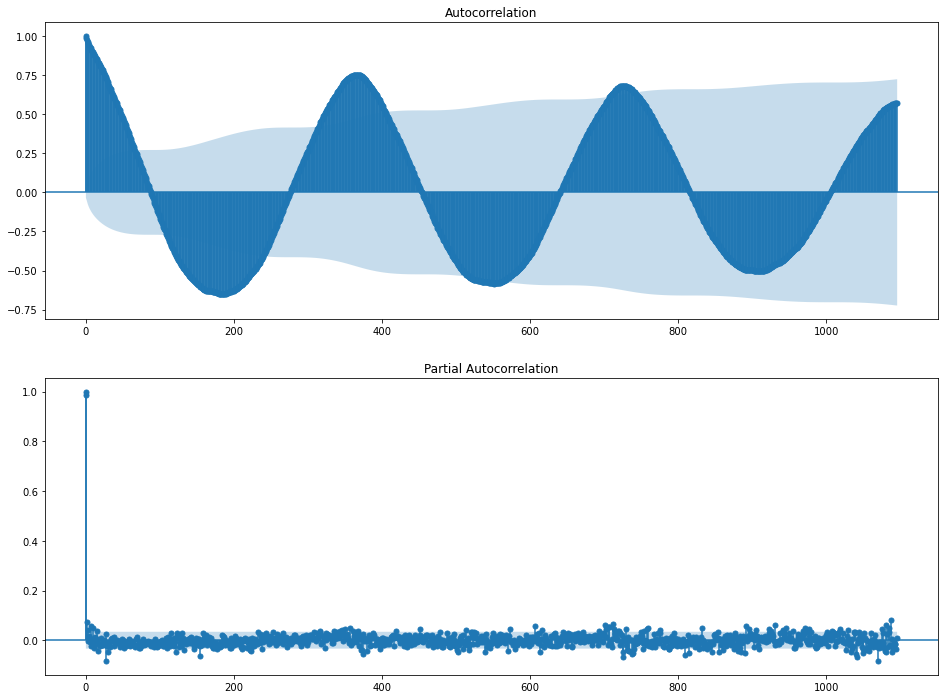

In [76]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(pabrc, lags=3*365, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(pabrc, lags=3*365, ax=ax[1])
plt.show()

In [78]:
pabrc_season_diff = pabrc.diff(365)
pabrc_diff = pabrc.diff()
pabrc_both = pabrc_season_diff.diff()

#### First difference ACF + PACF

Almost looks good, but you can still see the the cycle of no ice.

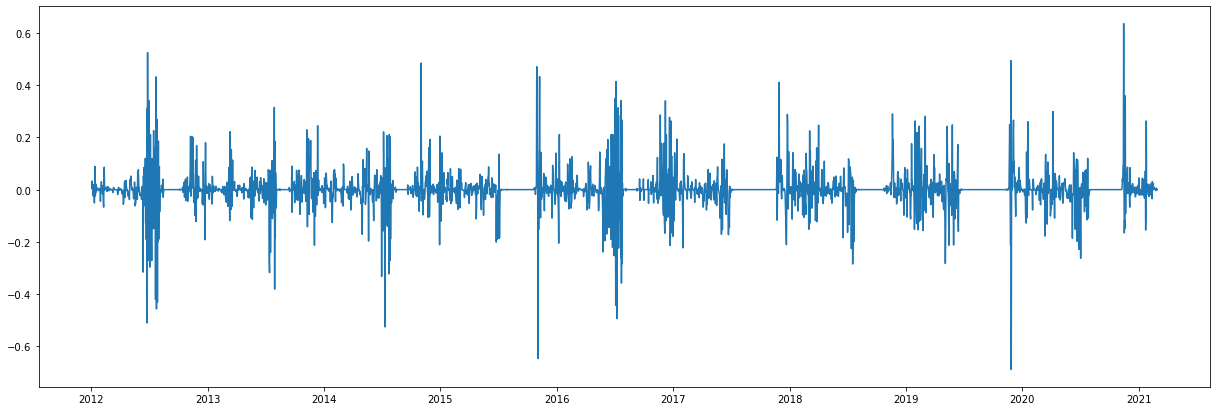

In [84]:
plt.figure(figsize=[21,7])
plt.plot(pabrc_diff[1:])

/env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


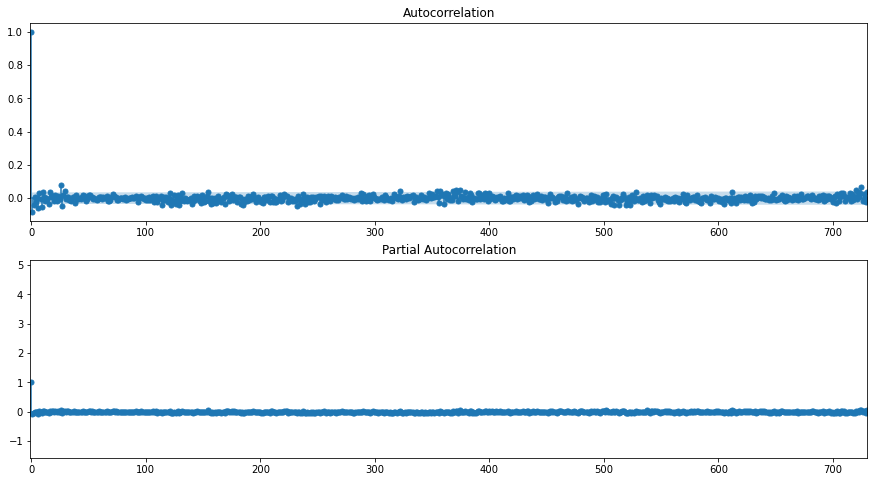

In [90]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(pabrc_diff[1:], lags=3*365, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(pabrc_diff[1:], lags=3*365, ax=ax[1])
ax[0].set_xlim(-1, 365*2)
ax[1].set_xlim(-1, 365*2)
plt.show()

In [95]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = stattools.adfuller(pabrc_diff[1:])
pvalue

1.570191963851078e-16

#### Seasonal ACF + PACF

Totally see seasonal signal.

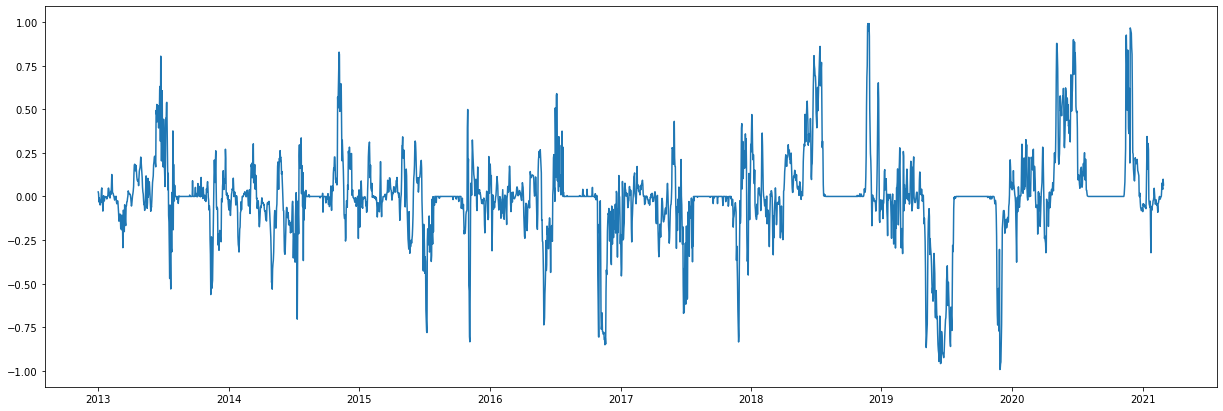

In [85]:
plt.figure(figsize=[21,7])
plt.plot(pabrc_season_diff)

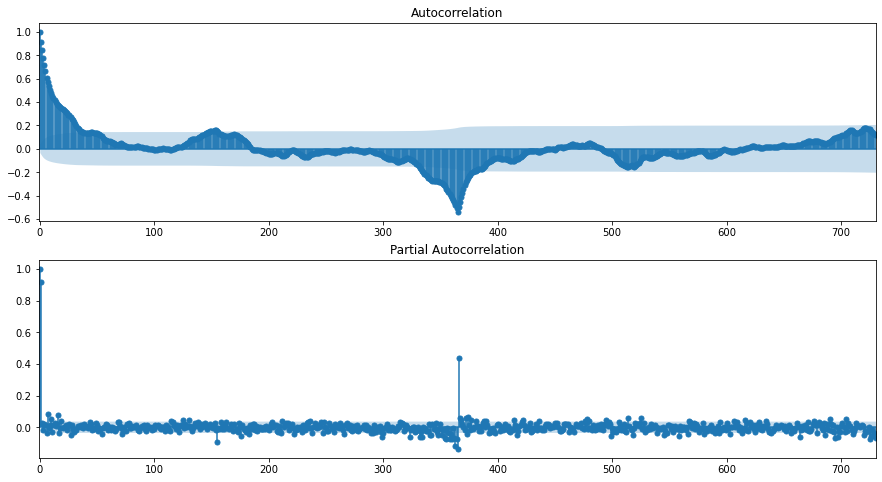

In [109]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(pabrc_season_diff[365::], lags=2*365, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(pabrc_season_diff[365::], lags=2*365, ax=ax[1])
ax[0].set_xlim(-1, 2*365)
ax[1].set_xlim(-1, 2*365)
plt.show()

#### Seasonal + First difference ACF + PACF

Almost looks good, but you can still see the the cycle of no ice.

<AxesSubplot:>

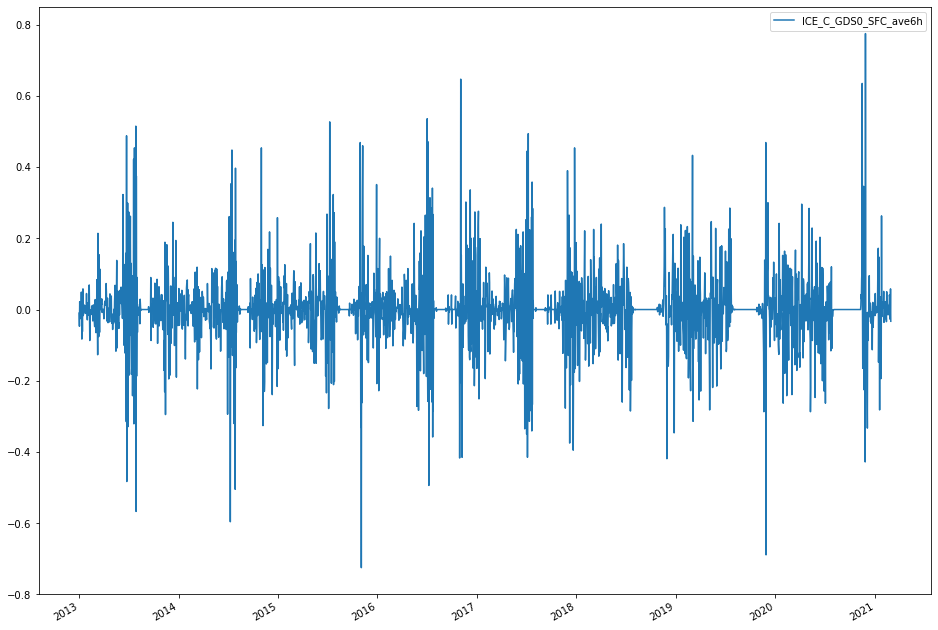

In [111]:
pabrc_both.plot()